In [1]:
CUDA_VISIBLE_DEVICES = "3"

In [2]:
import os
os.chdir("../")

In [3]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import tqdm
from flax.training import train_state
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tinygp
from tinygp import kernels, GaussianProcess
import tensorflow_probability.substrates.jax as tfp

dist = tfp.distributions

from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess


XLA_PYTHON_CLIENT_PREALLOCATE=False

## Dish Washer

In [ ]:
# train ={ 
#     1: {
#           'start_time': "2011-04-28" ,
#           'end_time': "2011-05-15"
#         },
#     # 3: {
#     #       'start_time': "2011-04-19" ,
#     #       'end_time': "2011-05-22"
#     # }
# }
# test = {
#      2: {
#           'start_time': "2011-04-21" ,
#           'end_time': "2011-05-21"
#     }
# }
# appliances = ["Dish Washer"]

In [ ]:
# x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)

In [ ]:
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
## pandas to hourly conversion

In [ ]:
# plt.plot(x_train)

In [ ]:
# plt.plot(y_test)

## Ref

In [4]:
train ={ 
        1:{
            'start_time': "2011-04-21" ,
            'end_time': "2011-05-21"
                }}

test ={2:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },}
appliances = ["Refrigerator"]

In [ ]:
# train ={1:{
#                     'start_time': "2011-04-21" ,
#                     'end_time': "2011-05-21"
#                 },
#                 3: {
#                     'start_time': "2011-04-19" ,
#                     'end_time': "2011-05-22"
#                 },
#                 2: {
#                     'start_time': "2011-04-21" ,
#                     'end_time': "2011-05-21"
#                 },
#                 5: {
#                     'start_time': "2011-04-22" ,
#                     'end_time': "2011-06-01"
#                 }
#                 }
# test = {6: {
#                     'start_time': "2011-05-25" ,
#                     'end_time': "2011-06-13"
#                 }}
# appliances = ["Refrigerator"]



In [5]:
x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)

When testing 1 building split:

In [6]:
x_1 = x_train[:13000,:]
x_2 = x_train[13000:19917,:]
y_1 = y_train[:13000]
y_2 = y_train[13000:19917]

print(x_1.shape, x_2.shape)

(13000, 1) (6917, 1)


(19917, 1) (19917,) (15656, 1) (15656,)


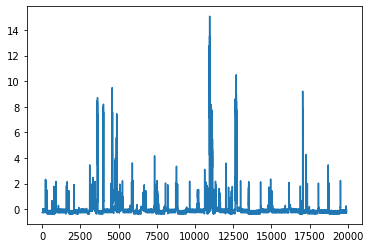

In [7]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
plt.plot(x_train)

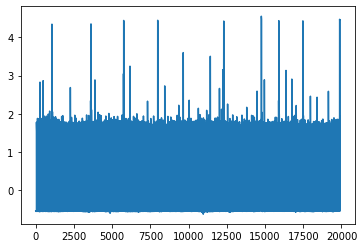

In [8]:
plt.plot(y_train)

## GP

In [8]:
import tensorflow_probability.substrates.jax as tfp
import jax.numpy as jnp
import jax
dist = tfp.distributions

In [9]:
def build_gp(theta_, x):
    # x = x/(jnp.exp(theta_["len_scale"]))
    kernel1 = (jnp.exp(theta_["varf_rbf"]))*kernels.ExpSquared(scale=jnp.exp(theta_["len_scale_rbf"]))
    kernel2 = (jnp.exp(theta_["varf"]))*kernels.ExpSineSquared(scale=jnp.exp(theta_["len_scale"]), gamma=jnp.exp(theta_["gamma"]))
    kernel3 =  (jnp.exp(theta_["varf_rbf1"]))*kernels.ExpSquared(scale=jnp.exp(theta_["len_scale_rbf1"]))
    kernel = kernel1 + kernel3*kernel2 
    return GaussianProcess(kernel, x, diag=(jnp.exp(theta_["vary"])))

# def build_gp(theta_, x):
#     # x = x/(jnp.exp(theta_["len_scale"]))
#     kernel = (jnp.exp(theta_["varf"]))*kernels.ExpSineSquared(scale=jnp.exp(theta_["len_scale"]), gamma=jnp.exp(theta_["gamma"]))
#     return GaussianProcess(kernel, x, diag=(jnp.exp(theta_["vary"])))

def NLL(theta_, x, y_):
    gp = build_gp(theta_, x)
    return -gp.log_probability(y_)

In [10]:
theta_init = {
  "varf": jnp.log(1.0),
  "varf_rbf": jnp.log(1.0),
  "varf_rbf1": jnp.log(1.0),
  "vary": jnp.log(1.0),
  "len_scale": jnp.log(1.0),
  "len_scale_rbf": jnp.log(1.0),
  "len_scale_rbf1": jnp.log(1.0),
  "gamma": jnp.log(1.0)}


obj = jax.jit(jax.value_and_grad(NLL))

print(f"Initial negative log likelihood: {obj(theta_init, x_1, y_1)[0]}")
# print(f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init,x_1, y_1)[1]}")
# print(f"Initial negative log likelihood: {obj(theta_init, x_train, y_train)[0]}")
# print(
#     f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init,x_train, y_train)[1]}")

Initial negative log likelihood: 15462.880859375


In [11]:
import jaxopt
solver = jaxopt.ScipyMinimize(fun=NLL, method='L-BFGS-B')
# print(X.shape, y.shape)
soln = solver.run(theta_init, x_1, y_1)
# soln = solver.run(theta_init, x_train, y_train)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 9549.0546875


In [ ]:
print(soln.params)
#{'gamma': DeviceArray(8.213193, dtype=float32), 'len_scale': DeviceArray(0.60124433, dtype=float32), 'varf': DeviceArray(-0.2495472, dtype=float32), 'vary': DeviceArray(-0.7555641, dtype=float32)}

In [12]:
# Nearest Neighbour calculation
from sklearn.neighbors import NearestNeighbors
batch_size = 5000
neigh = NearestNeighbors(n_neighbors=batch_size, algorithm='kd_tree')
neigh.fit(x_train)
_, neigh_idx = neigh.kneighbors(x_train, batch_size)
neigh_idx = jnp.array(neigh_idx)

In [ ]:
mean_ar1 = jnp.array([])
sigma_ar1 = jnp.array([])

for i in range(x_test.shape[0]):
  key = jax.random.PRNGKey(0)
  key = jax.random.split(key,2)
  center_idx = jax.random.randint(key[0], (1,), 1, len(y_train))
  nn_batch_indices = neigh_idx[center_idx, ]
  nn_batch_X = x_train[nn_batch_indices][:].squeeze()
  nn_batch_y = y_train[nn_batch_indices][:].squeeze()
  print(nn_batch_X.shape, nn_batch_y.shape)
  gp = build_gp(soln.params, nn_batch_X.reshape(-1,1))
  cond_gp = gp.condition(nn_batch_y, x_test[i : i + 1]).gp
  mu, var = cond_gp.loc, cond_gp.variance
  mean_ar1 = jnp.concatenate((mean_ar1, mu))
  sigma_ar1 = jnp.concatenate((sigma_ar1,jnp.sqrt(var)))


In [17]:
# # final_theta = {'gamma': jnp.log(jnp.exp(8.213193)), 'len_scale': jnp.log(jnp.exp(0.60124433)), 'varf': jnp.log(jnp.exp(-0.2495472)), 'vary': jnp.log(jnp.exp(-0.7555641))}
# gp = build_gp(soln.params, x_train)
# batch = 64
# if (len(y_test)%batch == 0):
#   num_batches = int(len(y_test)/batch)
# else:
#   num_batches = int(len(y_test)/batch) + 1
# index = 0
# mean_arr = []
# sigma_arr = []
# for i in range(num_batches):
#   if (index+batch <= len(y_test)):
#     x_test_batch = x_test[index:index+batch,:]
#   else:
#     x_test_batch = x_test[index:,:]
#   index = index+batch
#   print(x_test_batch.shape)
#   cond_gp = gp.condition(y_train, x_test_batch).gp
#   mu, var = cond_gp.loc, cond_gp.variance
#   mean_arr.append(mu)
#   sigma_arr.append(jnp.sqrt(var))
#   print(mu.shape,var.shape)


In [18]:
# mean_ar1 = jnp.array([])
# sigma_ar1 = jnp.array([])
# for i in range(len(mean_arr)):
#   mean_ar1 = jnp.concatenate((mean_ar1, mean_arr[i]))
#   sigma_ar1 = jnp.concatenate((sigma_ar1, sigma_arr[i]))
mean_ar1.shape, sigma_ar1.shape

((689,), (689,))

In [19]:
mean = scaler_y.inverse_transform(jnp.array(mean_ar1).reshape(-1,1)).squeeze()
sigma = scaler_y.scale_*jnp.array(sigma_ar1)
print(mean.shape, sigma.shape)
y_trans = scaler_y.inverse_transform(y_test[:689].reshape(-1,1)).reshape(-1,)

(689,) (689,)


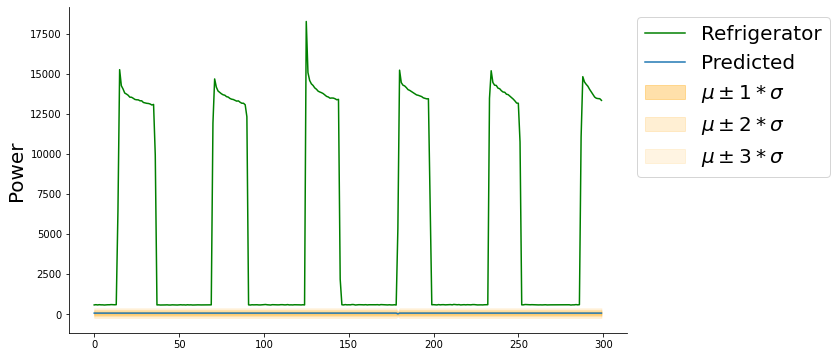

In [20]:
idx = 300
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_trans[:idx], label = "Refrigerator", color="green")
plt.plot(jnp.arange(idx), mean[:idx].reshape(-1,1), label = "Predicted")
for i in range(1,4):
    plt.fill_between(jnp.arange(idx), mean[:idx] - i*sigma[:idx], mean[:idx] + i*sigma[:idx],
                    color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.ylabel("Power", fontsize=20)
sns.despine()
plt.savefig("gp_ref_full.png")

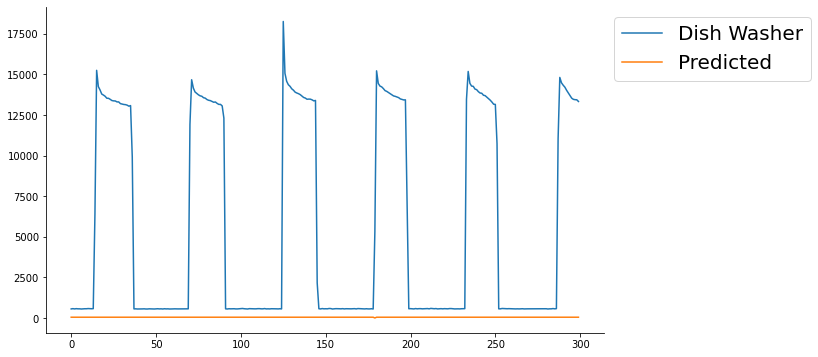

In [21]:
idx = 300
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_trans[:idx], label = "Dish Washer")
plt.plot(jnp.arange(idx), mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("gp_ref_full_.png", bbox_inches="tight")

In [ ]:
rms = errors.rmse(y_trans, mean)
print("RMSE:", rms)

nll = errors.NLL(mean, sigma, y_trans)
print("NLL:", nll)

## GPy

In [ ]:
# try:
#   import GPy
# except ModuleNotFoundError:
#   %pip install GPy
#   import GPy


In [ ]:
# sigmaf = 1
# len_scale =  1.0
# kernel1 = GPy.kern.RBF(1, sigmaf, len_scale)
# kernel2= GPy.kern.StdPeriodic(1, 1, 1.0, 1.0)
# kernel = kernel2
# model = GPy.models.GPRegression(x_1, y_1.reshape(-1,1), kernel, normalizer=False) 
# model.Gaussian_noise = 1.0
# print(model)
# model.plot()

In [ ]:
# model.optimize(messages=True)
# model.optimize_restarts(num_restarts = 3)

In [ ]:
# print(model)
# model.plot()